In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    FitzHughNagumoProcess,
    FitzHughNagumoAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

### Stochastic hypo-elliptic FitzHugh-Nagumo model
Consider a ODE/SDE-mixed model:
$$
\mathrm{d}X_t = \left\{
\begin{bmatrix}
    1/\varepsilon & -1/\varepsilon \\
    \gamma & -1
\end{bmatrix}X_t + 
\begin{bmatrix}
    -X^3_{t,1}/\varepsilon + s / \varepsilon \\
    b
\end{bmatrix}
\right\} \mathrm{d}t +
\begin{bmatrix}
    0 & 0 \\
    0 & \sigma
\end{bmatrix} \mathrm{d}W_t,
$$
where only the first component of $X_t$ is observed, that is $L = [1,0]$, construct the auxiliary process as:
$$
\mathrm{d}\tilde{X}_t = \left\{
\begin{bmatrix}
    1/\varepsilon-3\nu^3/\varepsilon & -1/\varepsilon \\
    \gamma & -1
\end{bmatrix}X_t + 
\begin{bmatrix}
    2\nu^3 /\varepsilon + s / \varepsilon \\
    b
\end{bmatrix}
\right\} \mathrm{d}t +
\begin{bmatrix}
    0 & 0 \\
    0 & \sigma
\end{bmatrix} \mathrm{d}W_t,
$$

In [3]:
dim = 2
T = 2.0
dt = 1. / 100
dtype = jnp.float32

# parameter settings, see "Simulation of Elliptic and Hypo-Elliptic Conditional Diffusions" (4.3)
epsilon = 0.1
s = 0.0
gamma = 1.5
b = 0.8
sigma = 0.3

seed = 42
u = jnp.array([-0.5, -0.6], dtype=dtype)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "quadratic"
ode_solver_kernel = "dopri5"

wiener_process = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = FitzHughNagumoProcess(epsilon, s, gamma, b, sigma, T, dim, dtype)
aux_proc = FitzHughNagumoAuxProcess(epsilon, s, gamma, b, sigma, T, dim, dtype)

ori_solver = Euler(ori_proc, wiener_process)
aux_solver = Euler(aux_proc, wiener_process)

rng_key = jax.random.PRNGKey(seed)

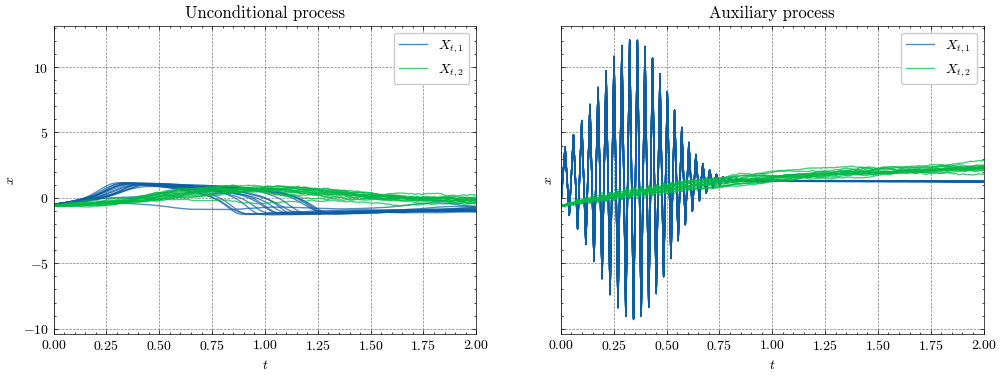

In [5]:
batch_size = 16
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plot_sample_path(ori_path, ax=axes[0], label=["$X_{t,1}$", "$X_{t,2}$"], title="Unconditional process")
plot_sample_path(aux_path, ax=axes[1], label=["$X_{t,1}$", "$X_{t,2}$"], title="Auxiliary process")
plt.show()

In [33]:
v = jnp.array([-1.0, 0.0], dtype=dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.array([1., 0.], dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(guided_proc, wiener_process)
guided_path = guided_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

IndexError: Too many indices: 1-dimensional array indexed with 2 regular indices.

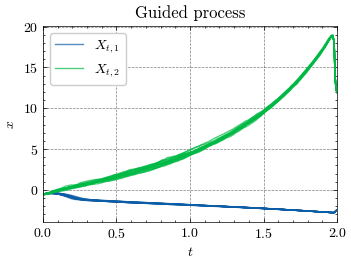

In [32]:
plot_sample_path(guided_path, label=["$X_{t,1}$", "$X_{t,2}$"], title="Guided process")
plt.show()